**MNIST and CIFAR-10 Classification using KNN, MLP, and CNN**

*Arman Gökalp*

In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import optuna

from sklearn.model_selection import ParameterGrid
import torch.nn.functional as F
from torchvision import datasets, transforms


from sklearn.decomposition import PCA

# **MNIST Classification**

In [ ]:
# Transforming to convert data to tensor and normalize it
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Loading MNIST training and test datasets
trainset_mnist = MNIST(root='./data', train=True, download=True, transform=transform_mnist)
testset_mnist = MNIST(root='./data', train=False, download=True, transform=transform_mnist)

# Creating data loaders for MNIST training and test sets
batch_size = 64
trainloader_mnist = DataLoader(trainset_mnist, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_mnist = DataLoader(testset_mnist, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 302160043.93it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 48825350.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 163976939.41it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5806317.82it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## **KNN for Classifying the MNIST Dataset**

In [ ]:
def dataloader_to_numpy(dataloader):
    images, labels = [], []
    for batch_images, batch_labels in dataloader:
        images.append(batch_images.view(batch_images.size(0), -1).numpy())
        labels.append(batch_labels.numpy())
    return np.vstack(images), np.hstack(labels)

X_train, y_train = dataloader_to_numpy(trainloader_mnist)

# Defining hyperparameter grid
param_grid = {'n_neighbors': [3, 5, 7], 'metric': ['euclidean', 'manhattan']}

# Create KNN classifier
knn = KNeighborsClassifier()

# Performing grid search with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

# Getting the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)
# 3hrs

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...metric=euclidean, n_neighbors=3;, score=0.970 total time=  46.1s
[CV 2/5] END ...metric=euclidean, n_neighbors=3;, score=0.970 total time=  41.6s
[CV 3/5] END ...metric=euclidean, n_neighbors=3;, score=0.971 total time=  42.7s
[CV 4/5] END ...metric=euclidean, n_neighbors=3;, score=0.972 total time=  42.7s
[CV 5/5] END ...metric=euclidean, n_neighbors=3;, score=0.973 total time=  42.8s
[CV 1/5] END ...metric=euclidean, n_neighbors=5;, score=0.970 total time=  42.3s
[CV 2/5] END ...metric=euclidean, n_neighbors=5;, score=0.967 total time=  40.0s
[CV 3/5] END ...metric=euclidean, n_neighbors=5;, score=0.972 total time=  41.2s
[CV 4/5] END ...metric=euclidean, n_neighbors=5;, score=0.971 total time=  42.1s
[CV 5/5] END ...metric=euclidean, n_neighbors=5;, score=0.973 total time=  41.5s
[CV 1/5] END ...metric=euclidean, n_neighbors=7;, score=0.969 total time=  41.1s
[CV 2/5] END ...metric=euclidean, n_neighbors=7;,

In [ ]:
# Creating and training the KNN classifier with the best hyperparameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [ ]:
X_test, y_test = dataloader_to_numpy(testloader_mnist)

# Prediction on the test data
y_pred = best_knn.predict(X_test)

# Computing the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)

Test accuracy: 0.9705


## **MLP for Classifying the MNIST Dataset**

In [ ]:
from torch.utils.data import random_split

# Splitting the training set into training and validation sets
train_size = int(0.8 * len(trainset_mnist))
val_size = len(trainset_mnist) - train_size
train_subset, val_subset = random_split(trainset_mnist, [train_size, val_size])

# Defining the MLP model
class MLP(nn.Module):
    def __init__(self, hidden_units1=512, hidden_units2=256):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_units1)
        self.fc2 = nn.Linear(hidden_units1, hidden_units2)
        self.fc3 = nn.Linear(hidden_units2, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def evaluate_model(model, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  return correct / total


model_mlp = MLP()

In [ ]:
import optuna

def objective(trial):
    # Hyperparameters to be optimized
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    hidden_units1 = trial.suggest_int('hidden_units1', 100, 500)
    hidden_units2 = trial.suggest_int('hidden_units2', 50, 300)

    # Define and train the MLP with these hyperparameters
    model = MLP(hidden_units1=hidden_units1, hidden_units2=hidden_units2)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, labels in trainloader_mnist:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model on the validation set
    val_accuracy = evaluate_model(model, val_loader)

    return val_accuracy


# Create a study object and specify the direction is 'maximize'
study = optuna.create_study(direction='maximize')

# Optimize the study, the objective function is passed in as the first argument
study.optimize(objective, n_trials=20)

# Results
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Value: ', trial.value)
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# 42 min


[I 2023-08-21 06:13:51,910] A new study created in memory with name: no-name-99f874e7-c3ce-4d5b-b13b-8de3c8653303
<ipython-input-8-50aa51059bb1>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
[I 2023-08-21 06:16:03,027] Trial 0 finished with value: 0.58925 and parameters: {'lr': 0.00021699917576934708, 'hidden_units1': 149, 'hidden_units2': 214}. Best is trial 0 with value: 0.58925.
[I 2023-08-21 06:18:13,024] Trial 1 finished with value: 0.8890833333333333 and parameters: {'lr': 0.001551765020628078, 'hidden_units1': 403, 'hidden_units2': 152}. Best is trial 1 with value: 0.8890833333333333.
[I 2023-08-21 06:20:14,678] Trial 2 finished with value: 0.811 and parameters: {'lr': 0.0005014326956570672, 'hidden_units1': 208, 'hidden_units2': 275}. Best is trial 1 with value: 0.88908

Number of finished trials:  20
Best trial:
Value:  0.9385
Params: 
    lr: 0.009200785403521235
    hidden_units1: 362
    hidden_units2: 96


In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., SGD)
optimizer = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in trainloader_mnist:
        optimizer.zero_grad()
        outputs = model_mlp(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [ ]:
# Evaluating final model on test data
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader_mnist:
        outputs = model_mlp(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_mlp = correct / total
print("Test accuracy:", accuracy_mlp)

Test accuracy: 0.9796


## **CNN for Classifying the MNIST Dataset**

In [ ]:
# Split into training and validation sets
train_size = int(0.8 * len(trainset_mnist))
val_size = len(trainset_mnist) - train_size
train_subset, val_subset = random_split(trainset_mnist, [train_size, val_size])

trainloader_mnist = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader_mnist = DataLoader(val_subset, batch_size=64, shuffle=False)
testloader_mnist = DataLoader(testset_mnist, batch_size=64, shuffle=False)

# Defining the CNN model
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc1_input_size = 9216
        self.fc1 = nn.Linear(self.fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [ ]:
# Function for evaluating the model
def evaluate_model(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Function for training and evaluating the model
def train_evaluate(params):
    model = CNN(dropout_rate=params['dropout_rate'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss()

    # Training
    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, labels in trainloader_mnist:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    val_accuracy = evaluate_model(model, val_loader_mnist)
    return val_accuracy

# Defining the hyperparameter values
learning_rates = [1e-3, 1e-2]
dropout_rates = [0.3, 0.5]

best_accuracy = 0
best_params = None

# Iterating through the hyperparameter combinations
for lr in learning_rates:
    for dropout_rate in dropout_rates:
        params = {'lr': lr, 'dropout_rate': dropout_rate}
        val_accuracy = train_evaluate(params)
        print("Params:", params, "Validation Accuracy:", val_accuracy)
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params

print("Best accuracy:", best_accuracy)
print("Best parameters:", best_params)

Params: {'lr': 0.001, 'dropout_rate': 0.3} Validation Accuracy: 0.98275
Params: {'lr': 0.001, 'dropout_rate': 0.5} Validation Accuracy: 0.9801666666666666
Params: {'lr': 0.01, 'dropout_rate': 0.3} Validation Accuracy: 0.11166666666666666
Params: {'lr': 0.01, 'dropout_rate': 0.5} Validation Accuracy: 0.11166666666666666
Best accuracy: 0.98275
Best parameters: {'lr': 0.001, 'dropout_rate': 0.3}


In [ ]:
# Initialize the model with the best hyperparameters
best_model = CNN(dropout_rate=best_params['dropout_rate'])

# Define the optimizer with the best learning rate
optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss()

# Training loop using the entire training set (including validation)
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in trainloader_mnist:
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate on the test set
test_accuracy = evaluate_model(best_model, testloader_mnist)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9869


## **Comparing the Models**

In [ ]:
print("Test Accuracy for k-NN model:", accuracy)
print("Test Accuracy for MLP model:", accuracy_mlp)
print("Test Accuracy for CNN model:", test_accuracy)

Test Accuracy for k-NN model: 0.9705
Test Accuracy for MLP model: 0.9796
Test Accuracy for CNN model: 0.9869


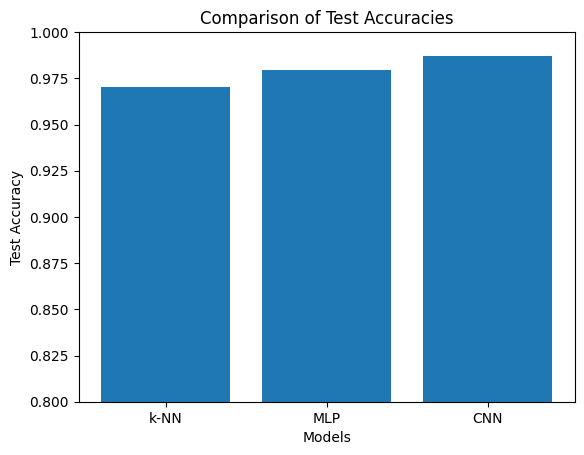

Best model is: CNN


In [ ]:
models = ['k-NN', 'MLP', 'CNN']
accuracies = [accuracy, accuracy_mlp, test_accuracy]

plt.bar(models, accuracies)
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracies')
plt.ylim(0.8, 1)
plt.show()


print(f'Best model is: {models[accuracies.index(max(accuracies))]}')

## **Error Analysis for the Best Model**

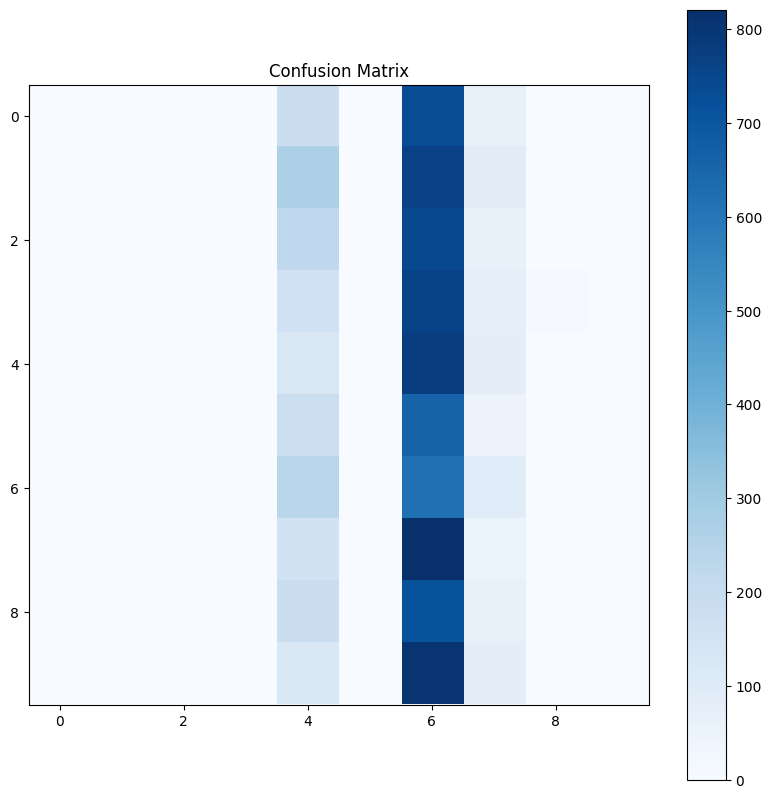

In [ ]:
# Get predictions and ground truth labels
y_true = []
y_pred = []
best_model = CNN(dropout_rate=best_params['dropout_rate'])
with torch.no_grad():
    for inputs, labels in testloader_mnist:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Computing the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = [str(i) for i in range(10)]


In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Setting diagonal elements to zero so we are only considering misclassification elements
np.fill_diagonal(conf_matrix, 0)

# Coordinates for the max value in the confusion matrix
row, col = np.unravel_index(conf_matrix.argmax(), conf_matrix.shape)

print(f"The most common misclassification is between class {row} and class {col}")

The most common misclassification is between class 7 and class 6


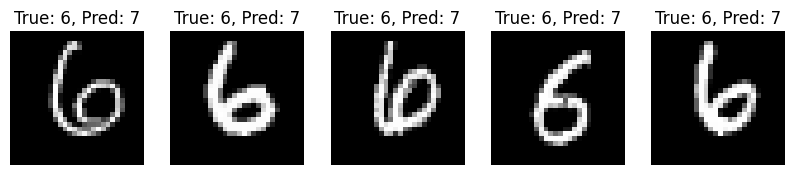

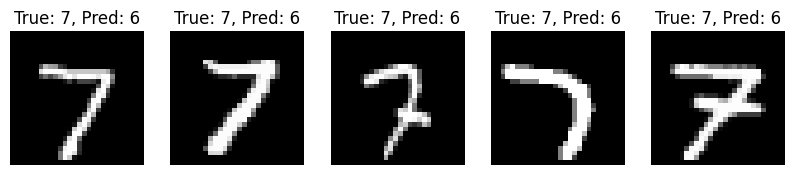

In [ ]:
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for inputs, labels in testloader_mnist:
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        mask = (predicted != labels) & ((labels == 6) & (predicted == 7) | (labels == 7) & (predicted == 6))
        misclassified_images.extend(inputs[mask])
        misclassified_labels.extend(labels[mask])
        misclassified_preds.extend(predicted[mask])

def visualize_misclassifications(actual_class, predicted_class, num_images=5):
    plt.figure(figsize=(10, 3))
    count = 0
    for img, true_label, pred_label in zip(misclassified_images, misclassified_labels, misclassified_preds):
        if true_label == actual_class and pred_label == predicted_class and count < num_images:
            plt.subplot(1, num_images, count + 1)
            plt.imshow(img.squeeze(), cmap="gray")
            plt.title(f"True: {true_label.item()}, Pred: {pred_label.item()}")
            plt.axis("off")
            count += 1
    plt.show()

# Predicted 7, actual 6
visualize_misclassifications(6, 7)

# PRedicted 6, actual 7
visualize_misclassifications(7, 6)


# **CIFAR-10 Classification**

In [ ]:
# Transforming to convert data to tensor and normalize it
transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Loading CIFAR-10 training and test datasets
trainset_cifar10 = CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
testset_cifar10 = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)

# Creating data loaders for CIFAR-10 training and test sets
batch_size = 64
trainloader_cifar10 = DataLoader(trainset_cifar10, batch_size=batch_size, shuffle=True, num_workers=2)
testloader_cifar10 = DataLoader(testset_cifar10, batch_size=batch_size, shuffle=False, num_workers=2)

# CIFAR-10 classes
classes_cifar10 = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:01<00:00, 99648507.95it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## **KNN for Classifying the CIFAR-10 Dataset**

In [ ]:
def dataloader_to_numpy(dataloader):
    images, labels = [], []
    for batch_images, batch_labels in dataloader:
        images.append(batch_images.view(batch_images.size(0), -1).numpy())
        labels.append(batch_labels.numpy())
    return np.vstack(images), np.hstack(labels)

# CIFAR-10 to numpy array
X_train_cifar10, y_train_cifar10 = dataloader_to_numpy(trainloader_cifar10)
X_test_cifar10, y_test_cifar10 = dataloader_to_numpy(testloader_cifar10)

# Apply PCA for dimensionality reduction
pca_cifar10 = PCA(n_components=100)  # You can change the number of components
X_train_cifar10_pca = pca_cifar10.fit_transform(X_train_cifar10)
X_test_cifar10_pca = pca_cifar10.transform(X_test_cifar10)

# Defining hyperparameter grid for k-NN
param_grid_cifar10 = {'n_neighbors': [3, 5, 7], 'metric': ['euclidean', 'manhattan']}

# Create KNN classifier
knn_cifar10 = KNeighborsClassifier()

# Performing grid search with 5-fold cross-validation
grid_search_cifar10 = GridSearchCV(knn_cifar10, param_grid_cifar10, cv=5, verbose=3)
grid_search_cifar10.fit(X_train_cifar10_pca, y_train_cifar10)

# Getting the best hyperparameters
best_params_cifar10 = grid_search_cifar10.best_params_
print("Best hyperparameters for CIFAR-10:", best_params_cifar10)

# Creating and training the k-NN classifier with the best hyperparameters
best_knn_cifar10 = KNeighborsClassifier(**best_params_cifar10)
best_knn_cifar10.fit(X_train_cifar10_pca, y_train_cifar10)

# Prediction on the test data
y_pred_cifar10 = best_knn_cifar10.predict(X_test_cifar10_pca)

# Computing the accuracy
accuracy_cifar10_knn = accuracy_score(y_test_cifar10, y_pred_cifar10)
print("Test accuracy for CIFAR-10 (k-NN):", accuracy_cifar10_knn)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...metric=euclidean, n_neighbors=3;, score=0.358 total time=   5.6s
[CV 2/5] END ...metric=euclidean, n_neighbors=3;, score=0.364 total time=   4.2s
[CV 3/5] END ...metric=euclidean, n_neighbors=3;, score=0.360 total time=   4.1s
[CV 4/5] END ...metric=euclidean, n_neighbors=3;, score=0.359 total time=   5.5s
[CV 5/5] END ...metric=euclidean, n_neighbors=3;, score=0.373 total time=   4.2s
[CV 1/5] END ...metric=euclidean, n_neighbors=5;, score=0.363 total time=   6.1s
[CV 2/5] END ...metric=euclidean, n_neighbors=5;, score=0.374 total time=   4.8s
[CV 3/5] END ...metric=euclidean, n_neighbors=5;, score=0.375 total time=   4.2s
[CV 4/5] END ...metric=euclidean, n_neighbors=5;, score=0.371 total time=   5.2s
[CV 5/5] END ...metric=euclidean, n_neighbors=5;, score=0.379 total time=   4.6s
[CV 1/5] END ...metric=euclidean, n_neighbors=7;, score=0.363 total time=   4.2s
[CV 2/5] END ...metric=euclidean, n_neighbors=7;,

## **MLP for Classifying the CIFAR-10 Dataset**

In [ ]:
# Creating data loaders for CIFAR-10 training and validation subsets
trainloader_cifar10 = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_cifar10 = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# Splitting the training set into training and validation sets
train_size = int(0.8 * len(trainset_cifar10))
val_size = len(trainset_cifar10) - train_size
train_subset, val_subset = random_split(trainset_cifar10, [train_size, val_size])

# Defining the MLP model
class MLP_CIFAR10(nn.Module):
    def __init__(self, hidden_units1=512, hidden_units2=256):
        super(MLP_CIFAR10, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, hidden_units1)
        self.fc2 = nn.Linear(hidden_units1, hidden_units2)
        self.fc3 = nn.Linear(hidden_units2, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def objective_cifar10(trial):
    # Hyperparameters to be optimized
    lr = trial.suggest_loguniform('lr', 1e-3, 1e-2)
    hidden_units1 = trial.suggest_int('hidden_units1', 100, 500)
    hidden_units2 = trial.suggest_int('hidden_units2', 50, 300)

    # Define and train the MLP with these hyperparameters
    model = MLP_CIFAR10(hidden_units1=hidden_units1, hidden_units2=hidden_units2)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, labels in trainloader_cifar10:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model on the validation set
    val_accuracy = evaluate_model(model, val_loader_cifar10)

    return val_accuracy

# Create study object
study_cifar10 = optuna.create_study(direction='maximize')

# Optimize study and pass the objective function as first argument
study_cifar10.optimize(objective_cifar10, n_trials=20)

# Results
print('Number of finished trials: ', len(study_cifar10.trials))
print('Best trial:')
trial_cifar10 = study_cifar10.best_trial

print('Value: ', trial_cifar10.value)
best_lr = trial_cifar10.params['lr']
best_hidden_units1 = trial_cifar10.params['hidden_units1']
best_hidden_units2 = trial_cifar10.params['hidden_units2']
print('Best Params:', best_lr, best_hidden_units1, best_hidden_units2)

for key, value in trial_cifar10.params.items():
    print(f'    {key}: {value}')


[I 2023-08-21 12:02:47,636] A new study created in memory with name: no-name-48a7c457-d9a4-48a5-a2a4-dc4841e1f59f
<ipython-input-103-cf690c285e57>:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-3, 1e-2)
[I 2023-08-21 12:05:20,649] Trial 0 finished with value: 0.3783 and parameters: {'lr': 0.0019111974391212228, 'hidden_units1': 185, 'hidden_units2': 229}. Best is trial 0 with value: 0.3783.
[I 2023-08-21 12:08:10,751] Trial 1 finished with value: 0.4756 and parameters: {'lr': 0.006721749583494598, 'hidden_units1': 415, 'hidden_units2': 180}. Best is trial 1 with value: 0.4756.
[I 2023-08-21 12:10:59,443] Trial 2 finished with value: 0.4754 and parameters: {'lr': 0.008108434223103828, 'hidden_units1': 360, 'hidden_units2': 173}. Best is trial 1 with value: 0.4756.
[I 2023-08-21 12:13:36,

Number of finished trials:  20
Best trial:
Value:  0.5067
Best Params: 0.009937017892464617 497 53
    lr: 0.009937017892464617
    hidden_units1: 497
    hidden_units2: 53


In [ ]:
class MLP_CIFAR10(nn.Module):
    def __init__(self, hidden_units1=512, hidden_units2=256):
        super(MLP_CIFAR10, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, hidden_units1)
        self.fc2 = nn.Linear(hidden_units1, hidden_units2)
        self.fc3 = nn.Linear(hidden_units2, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model_mlp_cifar10 = MLP_CIFAR10(hidden_units1=best_hidden_units1, hidden_units2=best_hidden_units2)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (e.g., SGD)
optimizer = optim.SGD(model_mlp_cifar10.parameters(), lr=best_lr, momentum=0.9)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in trainloader_cifar10:
        optimizer.zero_grad()
        outputs = model_mlp_cifar10(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluating final model on test data
accuracy_mlp_cifar10 = evaluate_model(model_mlp_cifar10, testloader_cifar10)
print("Test accuracy for CIFAR-10 (MLP):", accuracy_mlp_cifar10)

Test accuracy for CIFAR-10 (MLP): 0.5189


## **CNN for Classifying the CIFAR-10 Dataset**

In [ ]:
# Splitting the data into training and validation sets
train_size_cifar10 = int(0.8 * len(trainset_cifar10))
val_size_cifar10 = len(trainset_cifar10) - train_size_cifar10
train_subset_cifar10, val_subset_cifar10 = random_split(trainset_cifar10, [train_size_cifar10, val_size_cifar10])

trainloader_cifar10 = DataLoader(train_subset_cifar10, batch_size=64, shuffle=True)
val_loader_cifar10 = DataLoader(val_subset_cifar10, batch_size=64, shuffle=False)

In [ ]:
class CNN_CIFAR10(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(CNN_CIFAR10, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

def train_evaluate_cifar10(params):
    model = CNN_CIFAR10(dropout_rate=params['dropout_rate'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss()

    # Training
    num_epochs = 10
    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for inputs, labels in trainloader_cifar10:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

      epoch_loss = running_loss / len(trainloader_cifar10.dataset)
      print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_loss}")

    val_accuracy = evaluate_model(model, val_loader_cifar10)
    return val_accuracy

learning_rates_cifar10 = [1e-3, 1e-4]
dropout_rates_cifar10 = [0.3, 0.5]

best_accuracy_cifar10 = 0
best_params_cifar10 = None

# Iterating through the hyperparameter combinations
for lr in learning_rates_cifar10:
    for dropout_rate in dropout_rates_cifar10:
        params_cifar10 = {'lr': lr, 'dropout_rate': dropout_rate}
        val_accuracy_cifar10 = train_evaluate_cifar10(params_cifar10)
        print("Params:", params_cifar10, "Validation Accuracy:", val_accuracy_cifar10)
        if val_accuracy_cifar10 > best_accuracy_cifar10:
            best_accuracy_cifar10 = val_accuracy_cifar10
            best_params_cifar10 = params_cifar10

print("Best accuracy:", best_accuracy_cifar10)
print("Best parameters:", best_params_cifar10)

Epoch 1/10 - Training Loss: 1.629682534790039
Epoch 2/10 - Training Loss: 1.2935339420318603
Epoch 3/10 - Training Loss: 1.1143361022949219
Epoch 4/10 - Training Loss: 0.9883827204704285
Epoch 5/10 - Training Loss: 0.8912826970100403
Epoch 6/10 - Training Loss: 0.8132527493953705
Epoch 7/10 - Training Loss: 0.7641592841148377
Epoch 8/10 - Training Loss: 0.7139746475696563
Epoch 9/10 - Training Loss: 0.6729323338508606
Epoch 10/10 - Training Loss: 0.6347983441352845
Params: {'lr': 0.001, 'dropout_rate': 0.3} Validation Accuracy: 0.7389
Epoch 1/10 - Training Loss: 1.6811346324920655
Epoch 2/10 - Training Loss: 1.3335392119407654
Epoch 3/10 - Training Loss: 1.1806680936813354
Epoch 4/10 - Training Loss: 1.0731873594284058
Epoch 5/10 - Training Loss: 0.9895928985595703
Epoch 6/10 - Training Loss: 0.9273958760261536
Epoch 7/10 - Training Loss: 0.8904425423622131
Epoch 8/10 - Training Loss: 0.8449645387649536
Epoch 9/10 - Training Loss: 0.8108072228431702
Epoch 10/10 - Training Loss: 0.78566

In [ ]:
# Combining the training and validation subsets for final training
final_trainloader_cifar10 = DataLoader(trainset_cifar10, batch_size=64, shuffle=True)

# Hyperparameters obtained from previous tuning
best_lr_cifar10 = 0.001
best_dropout_rate_cifar10 = 0.3

# Defining and training the model with the best hyperparameters
final_model_cifar10 = CNN_CIFAR10(dropout_rate=best_dropout_rate_cifar10)
final_optimizer_cifar10 = optim.Adam(final_model_cifar10.parameters(), lr=best_lr_cifar10)
final_criterion_cifar10 = nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in final_trainloader_cifar10:
        final_optimizer_cifar10.zero_grad()
        outputs = final_model_cifar10(inputs)
        loss = final_criterion_cifar10(outputs, labels)
        loss.backward()
        final_optimizer_cifar10.step()

# Evaluating the model on the test set
test_accuracy_cifar10 = evaluate_model(final_model_cifar10, testloader_cifar10)
print("Test accuracy for CIFAR-10 (CNN):", test_accuracy_cifar10)

Test accuracy for CIFAR-10 (CNN): 0.7514


## **Comparing the Models**

In [ ]:
cifar10_accuracies = {
    'k-NN': accuracy_cifar10_knn,
    'MLP': accuracy_mlp_cifar10,
    'CNN': test_accuracy_cifar10
}

print("Summary of accuracies for CIFAR-10:")
for model, accuracy in cifar10_accuracies.items():
    print(f"{model}: {accuracy * 100:.2f}%")

Summary of accuracies for CIFAR-10:
k-NN: 38.11%
MLP: 51.89%
CNN: 75.14%


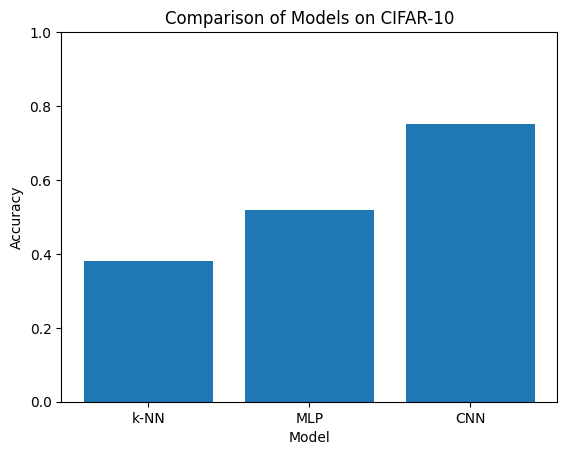

In [ ]:
models = ['k-NN', 'MLP', 'CNN']
accuracies_cifar10 = [accuracy_cifar10_knn, accuracy_mlp_cifar10, test_accuracy_cifar10]

plt.bar(models, accuracies_cifar10)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Comparison of Models on CIFAR-10')
plt.show()

## **Error Analysis for the Best Model**

In [ ]:
# Preparing the training data
X_train_cifar10 = []
y_train_cifar10 = []

for images, labels in trainloader_cifar10:
    images_flat = images.view(images.shape[0], -1).numpy()
    X_train_cifar10.extend(images_flat)
    y_train_cifar10.extend(labels.numpy())

# Initializing and training the k-NN classifier
knn_cifar10 = KNeighborsClassifier(n_neighbors=3)
knn_cifar10.fit(X_train_cifar10, y_train_cifar10)

KNeighborsClassifier(n_neighbors=3)

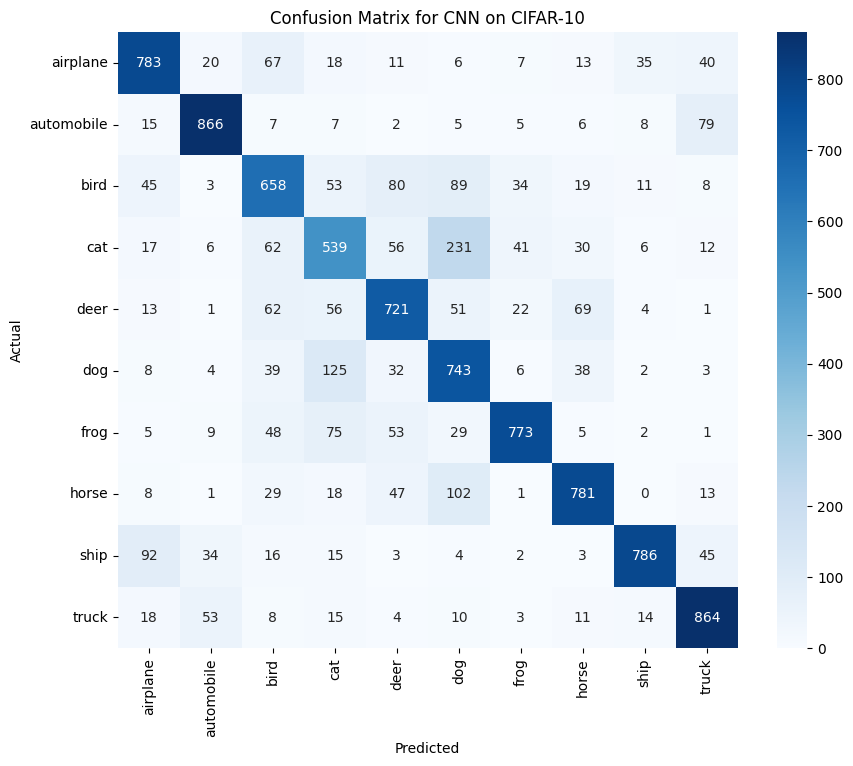

In [ ]:
# Function to get predictions
def get_predictions(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
    return y_true, y_pred

# Getting the true and predicted labels
y_true_cifar10, y_pred_cifar10 = get_predictions(final_model_cifar10, testloader_cifar10)

# Computing the confusion matrix
conf_matrix_cifar10 = confusion_matrix(y_true_cifar10, y_pred_cifar10)

# Defining the CIFAR-10 class labels
class_labels_cifar10 = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Ploting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cifar10, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels_cifar10, yticklabels=class_labels_cifar10)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CNN on CIFAR-10')
plt.show()

In [ ]:
# Setting diagonal elements to zero to consider only misclassifications
np.fill_diagonal(conf_matrix_cifar10, 0)

# Coordinates for the max value in the confusion matrix
row_cifar10, col_cifar10 = np.unravel_index(conf_matrix_cifar10.argmax(), conf_matrix_cifar10.shape)

print(f"The most common misclassification in CIFAR-10 is between class {row_cifar10} and class {col_cifar10}")


The most common misclassification in CIFAR-10 is between class 3 and class 5


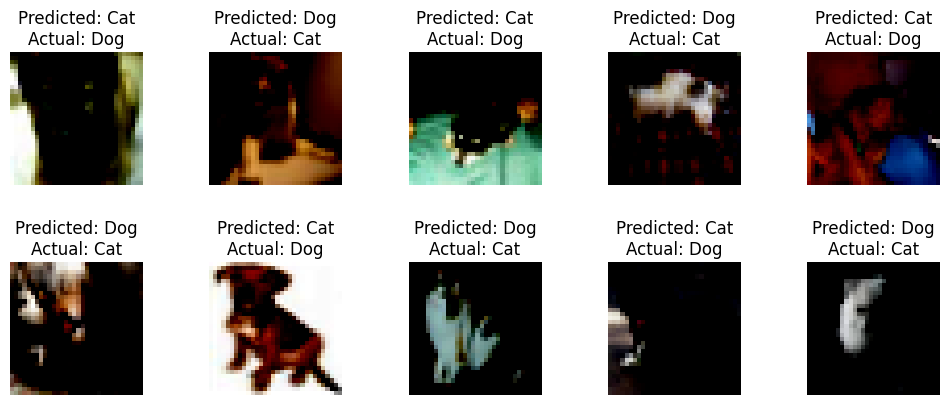

In [ ]:
misclassified_cats_and_dogs = [(img, pred) for img, true, pred in zip(X_test_cifar10, y_true_cifar10, y_pred_cifar10) if (true, pred) == (3, 5) or (true, pred) == (5, 3)]

# Displaying some misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in np.arange(10):
    image = misclassified_cats_and_dogs[i][0]

    # Reshaping considering the channel order
    image = image.reshape(3, 32, 32).transpose(1, 2, 0)

    # Normalization [0, 1]
    if image.max() > 1:
        image = image / 255.0

    # Clipping to make sure all values are in the [0, 1] range
    image = np.clip(image, 0, 1)

    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {'Dog' if misclassified_cats_and_dogs[i][1] == 5 else 'Cat'}\nActual: {'Cat' if misclassified_cats_and_dogs[i][1] == 5 else 'Dog'}")
    axes[i].axis('off')


plt.subplots_adjust(wspace=0.5)
plt.show()